In [1]:
# import libraries
import pm4py
import editdistance
import pandas as pd
from label_functions import *

In [3]:
# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

event_log = import_xes("data/Hospital_log.xes.gz")

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

In [4]:
# convert all activity codes to strings
event_log['Activity code'] = event_log['Activity code'].astype(str)

# get all traces
all_traces = event_log.groupby('case:concept:name')['Activity code'].apply(list)

In [112]:
# def get_similar_traces(running_trace, traces, threshold=40):
    
#     # convert running trace to list if it is a series
#     if isinstance(running_trace, pd.Series):
#         running_trace = running_trace.iloc[0]
    
#     # find similar traces
#     similar_traces = []
#     for case, activities in traces.items():
#         distance = editdistance.eval(running_trace, activities)
#         if distance <= threshold:
#             similar_traces.append((case, distance))
#     return dict(similar_traces)

In [6]:
def get_similarity(running_trace, traces, similarity=True):
    '''
    Calculate edit distances between running trace and all traces in the log.
    Convert to similarity score if similarity=True.
    '''
    # convert running trace to list if it is a series
    if isinstance(running_trace, pd.Series):
        running_trace = running_trace.iloc[0]
    
    # calculate edit distances
    str_edit_dist = []
    for case, activities in traces.items():
        distance = editdistance.eval(running_trace, activities)
        if similarity:
            similarity_score = 1 - distance / max(len(running_trace), len(activities))
            str_edit_dist.append((case, similarity_score))
        else:
            str_edit_dist.append((case, distance))
    return dict(str_edit_dist)

In [24]:
# sample random trace
running_trace = all_traces.sample(1)
historic_traces = all_traces.drop(running_trace.index)

# TODO: prefix extraction of historic traces?

# calculate similarity scores
similarity_scores = get_similarity(running_trace, historic_traces, similarity=True)

# get n most similar traces
n = 100
sorted_similar_traces = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
most_similar_traces = sorted_similar_traces[:n]

In [8]:
# # sample random trace
# running_trace = all_traces.sample(1)
# historic_traces = all_traces.drop(running_trace.index)

# # get similar traces
# similar_traces = get_similar_traces(running_trace, historic_traces, threshold=80)
# print(len(similar_traces))

In [25]:
similar_traces_list = [x[0] for x in most_similar_traces]
lf_map = get_lf_map(event_log, label_function_1)
y_train = [lf_map[trace] for trace in similar_traces_list]

print(f'{sum(y_train)} out of {len(y_train)} traces are positive')

44 out of 100 traces are positive


In [12]:
last_event = event_log[event_log['case:concept:name'] == similar_traces_list[5]].tail(1)

# get values of all columns starting with case:Diagnosis
diagnosis_columns = [col for col in event_log.columns if col.startswith('case:Diagnosis')]
diagnosis_values = last_event[diagnosis_columns]
diagnosis_values

,case:Diagnosis code:2,case:Diagnosis code:1,case:Diagnosis:2,case:Diagnosis:1,case:Diagnosis,case:Diagnosis Treatment Combination ID,case:Diagnosis Treatment Combination ID:2,case:Diagnosis code,case:Diagnosis Treatment Combination ID:1,case:Diagnosis code:3,...,case:Diagnosis Treatment Combination ID:15,case:Diagnosis Treatment Combination ID:14,case:Diagnosis:15,case:Diagnosis:14,case:Diagnosis:11,case:Diagnosis:13,case:Diagnosis:12,case:Diagnosis code:14,case:Diagnosis code:13,case:Diagnosis code:15
30895,NaN,NaN,NaN,NaN,maligniteit vulva,238446.0,NaN,M11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
X_cols = ['case:Diagnosis code', 'case:Treatment code']
for col in diagnosis_columns:
    print(col)
    x = event_log.groupby('case:concept:name')[col].last().notna().sum() / event_log['case:concept:name'].nunique()
    print(x)

case:Diagnosis code:2
0.5704286964129484
case:Diagnosis code:1
0.5704286964129484
case:Diagnosis:2
0.5704286964129484
case:Diagnosis:1
0.5704286964129484
case:Diagnosis
0.6019247594050744
case:Diagnosis Treatment Combination ID
0.6019247594050744
case:Diagnosis Treatment Combination ID:2
0.5704286964129484
case:Diagnosis code
0.6019247594050744
case:Diagnosis Treatment Combination ID:1
0.5704286964129484
case:Diagnosis code:3
0.36395450568678916
case:Diagnosis:3
0.36395450568678916
case:Diagnosis Treatment Combination ID:3
0.36395450568678916
case:Diagnosis code:4
0.10323709536307961
case:Diagnosis:4
0.10323709536307961
case:Diagnosis Treatment Combination ID:4
0.10323709536307961
case:Diagnosis code:5
0.023622047244094488
case:Diagnosis:5
0.023622047244094488
case:Diagnosis Treatment Combination ID:5
0.023622047244094488
case:Diagnosis code:10
0.0017497812773403325
case:Diagnosis Treatment Combination ID:10
0.0017497812773403325
case:Diagnosis:10
0.0017497812773403325
case:Diagnosis c

In [16]:
y_test = lf_map[running_trace.index[0]]
y_test

True

### Visualizations

In [123]:
df_list = []
for th in range(0, 205, 10):
    n_similar_traces = []
    for _ in range(50):
        running_trace = all_traces.sample(1)
        historic_traces = all_traces.drop(running_trace.index)
        similar_traces = get_similar_traces(running_trace, historic_traces, threshold=th)
        n_similar_traces.append(len(similar_traces))
    mean_similar_traces = sum(n_similar_traces) / len(n_similar_traces)
    min_similar_traces = min(n_similar_traces)
    df_list.append([th, mean_similar_traces, min_similar_traces])

df_th = pd.DataFrame(df_list, columns=['Threshold', 'Mean similar traces', 'Min similar traces'])

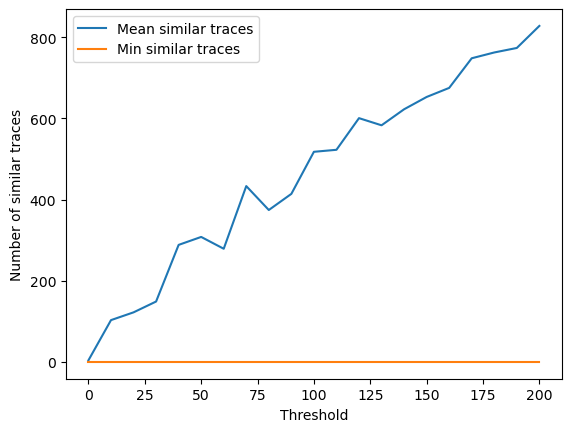

In [124]:
# plot threshold and number of similar traces
import matplotlib.pyplot as plt

plt.plot(df_th['Threshold'], df_th['Mean similar traces'], label='Mean similar traces')
plt.plot(df_th['Threshold'], df_th['Min similar traces'], label='Min similar traces')
plt.xlabel('Threshold')
plt.ylabel('Number of similar traces')
plt.legend()